[参考](https://nbviewer.jupyter.org/github/ahmedbesbes/How-to-score-0.8134-in-Titanic-Kaggle-Challenge/blob/master/article_1.ipynb)。

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [2]:
train.drop(['Survived'], axis=1, inplace=True)
combined = train.append(test, sort=False)
combined.reset_index(inplace=True)
combined.drop(['index', 'PassengerId'], inplace=True, axis=1)
combined.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
combined['Title'] = combined['Name'].map(
    lambda name: name.split(',')[1].split('.')[0].strip())

Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir": "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess": "Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr": "Mr",
    "Mrs": "Mrs",
    "Miss": "Miss",
    "Master": "Master",
    "Lady": "Royalty"
}

combined['Title'] = combined.Title.map(Title_Dictionary)

In [4]:
grouped_train = combined.iloc[:891].groupby(['Sex','Pclass','Title'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]
grouped_median_train

,Sex,Pclass,Title,Age
0,female,1,Miss,30.0
1,female,1,Mrs,40.0
2,female,1,Officer,49.0
3,female,1,Royalty,40.5
4,female,2,Miss,24.0
5,female,2,Mrs,31.5
6,female,3,Miss,18.0
7,female,3,Mrs,31.0
8,male,1,Master,4.0
9,male,1,Mr,40.0


In [5]:
def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Title'] == row['Title']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    return grouped_median_train[condition]['Age'].values[0]

combined['Age'] = combined.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)

In [6]:
combined.drop('Name', axis=1, inplace=True)
titles_dummies = pd.get_dummies(combined['Title'], prefix='Title')
combined = pd.concat([combined, titles_dummies], axis=1)
combined.drop('Title', axis=1, inplace=True)

In [7]:
combined.Fare.fillna(combined.iloc[:891].Fare.mean(), inplace=True)

In [8]:
combined.Embarked.fillna('S', inplace=True)
embarked_dummies = pd.get_dummies(combined['Embarked'], prefix='Embarked')
combined = pd.concat([combined, embarked_dummies], axis=1)
combined.drop('Embarked', axis=1, inplace=True)

In [9]:
train_cabin, test_cabin = set(), set()

for c in combined.iloc[:891]['Cabin']:
    try:
        train_cabin.add(c[0])
    except:
        train_cabin.add('U')
        
for c in combined.iloc[891:]['Cabin']:
    try:
        test_cabin.add(c[0])
    except:
        test_cabin.add('U')


In [10]:
train_cabin

{'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'U'}

In [11]:
test_cabin

{'A', 'B', 'C', 'D', 'E', 'F', 'G', 'U'}

In [12]:
combined.Cabin.fillna('U', inplace=True)
combined['Cabin'] = combined['Cabin'].map(lambda c: c[0])

cabin_dummies = pd.get_dummies(combined['Cabin'], prefix='Cabin')    
combined = pd.concat([combined, cabin_dummies], axis=1)

combined.drop('Cabin', axis=1, inplace=True)

In [13]:
combined['Sex'] = combined['Sex'].map({'male':1, 'female':0})

In [14]:
pclass_dummies = pd.get_dummies(combined['Pclass'], prefix="Pclass")
combined = pd.concat([combined, pclass_dummies],axis=1)
combined.drop('Pclass',axis=1,inplace=True)

In [15]:
def cleanTicket(ticket):
    ticket = ticket.replace('.', '')
    ticket = ticket.replace('/', '')
    ticket = ticket.split()
    ticket = map(lambda t : t.strip(), ticket)
    ticket = list(filter(lambda t : not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else: 
        return 'XXX'

In [16]:
tickets = set()
for t in combined['Ticket']:
    tickets.add(cleanTicket(t))

In [17]:
# a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
def cleanTicket(ticket):
    ticket = ticket.replace('.', '')
    ticket = ticket.replace('/', '')
    ticket = ticket.split()
    ticket = map(lambda t: t.strip(), ticket)
    ticket = list(filter(lambda t: not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else:
        return 'XXX'


# Extracting dummy variables from tickets:

combined['Ticket'] = combined['Ticket'].map(cleanTicket)
tickets_dummies = pd.get_dummies(combined['Ticket'], prefix='Ticket')
combined = pd.concat([combined, tickets_dummies], axis=1)
combined.drop('Ticket', inplace=True, axis=1)

In [18]:
# introducing a new feature : the size of families (including the passenger)
combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1

# introducing other features based on the family size
combined['Singleton'] = combined['FamilySize'].map(
    lambda s: 1 if s == 1 else 0)
combined['SmallFamily'] = combined['FamilySize'].map(
    lambda s: 1 if 2 <= s <= 4 else 0)
combined['LargeFamily'] = combined['FamilySize'].map(
    lambda s: 1 if 5 <= s else 0)

In [19]:
targets = pd.read_csv('../input/train.csv', usecols=['Survived'])['Survived'].values

In [20]:
train = combined.iloc[:891]
test = combined.iloc[891:]

In [21]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(train, targets)

In [22]:
features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

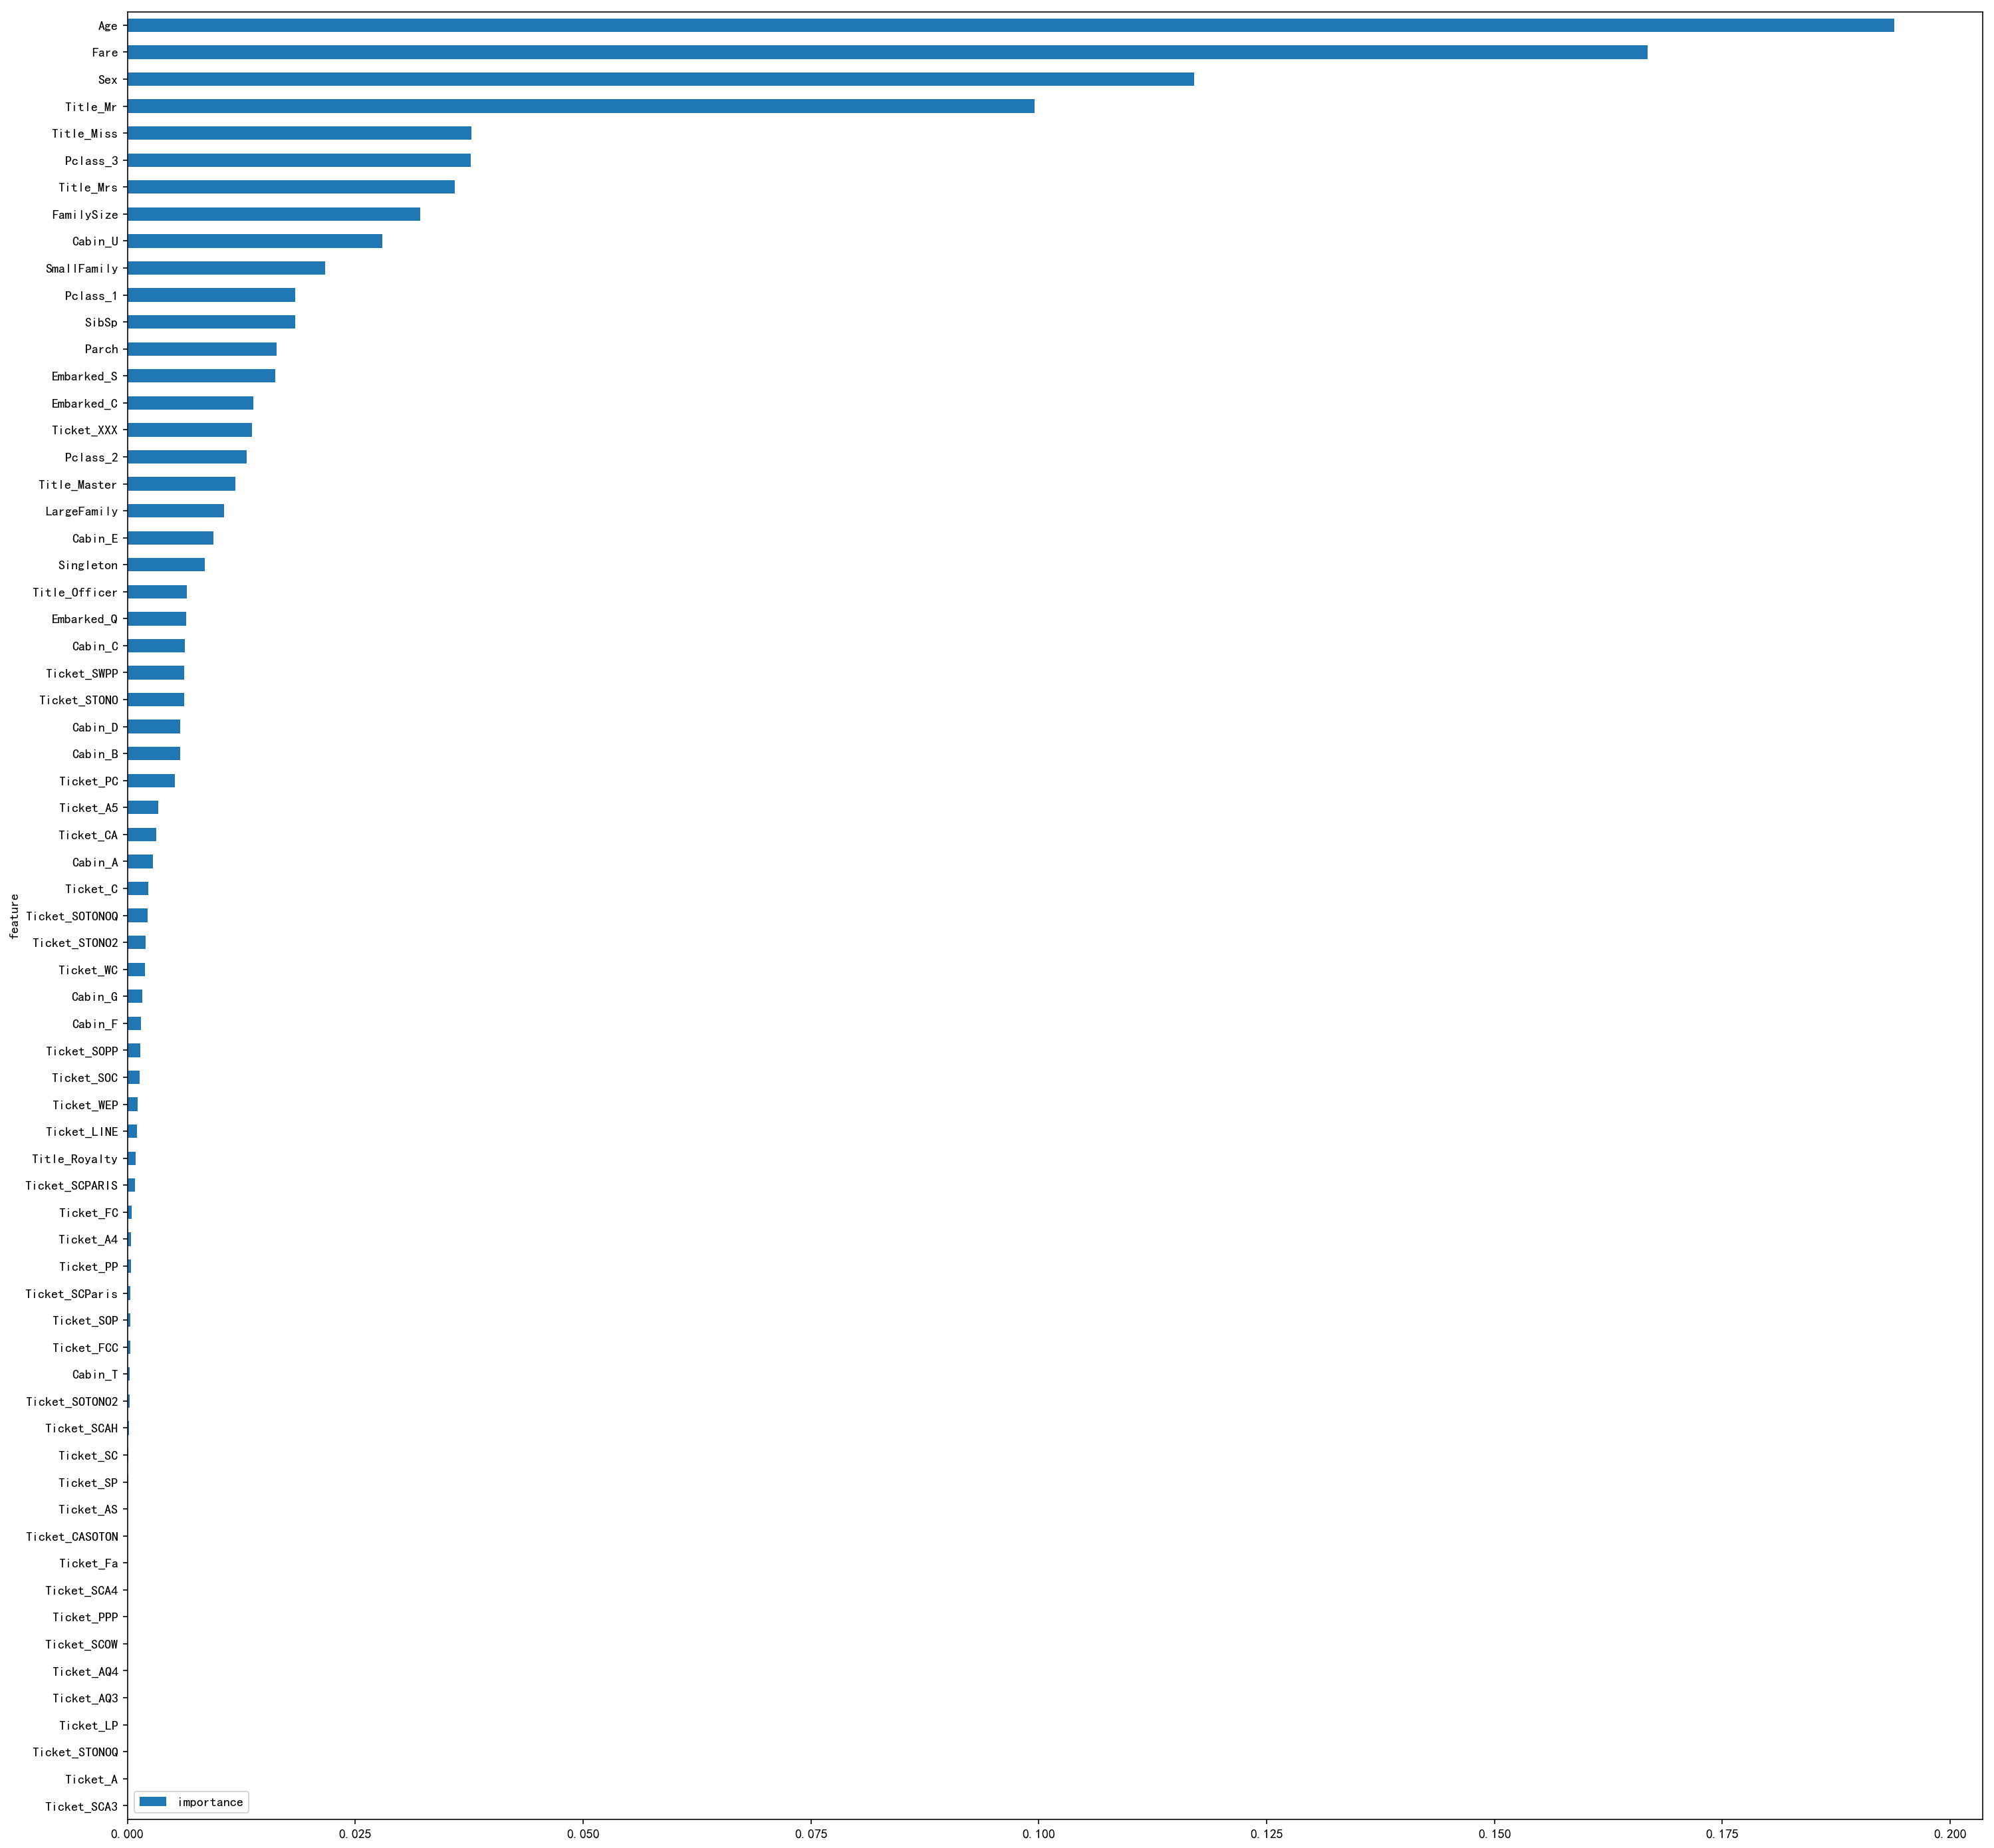

In [23]:
features.plot(kind='barh', figsize=(25, 25))
plt.show()

In [24]:
from sklearn.feature_selection import SelectFromModel

model = SelectFromModel(clf, prefit=True)
train_reduced = model.transform(train)
test_reduced = model.transform(test)

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

logreg = LogisticRegression(solver='newton-cg')
logreg_cv = LogisticRegressionCV()
rf = RandomForestClassifier(n_estimators=100)
gboost = GradientBoostingClassifier()

models = [logreg, logreg_cv, rf, gboost]

In [26]:
from sklearn.model_selection import cross_val_score

def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)

In [27]:
for model in models:
    print('Cross-validation of : {0}'.format(model.__class__))
    score = compute_score(
        clf=model, X=train_reduced, y=targets, scoring='accuracy')
    print('CV score = {0}'.format(score))
    print('****')

Cross-validation of : <class 'sklearn.linear_model.logistic.LogisticRegression'>
CV score = 0.8159668088405259
****
Cross-validation of : <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>


/Users/liwei/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/liwei/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/liwei/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/liwei/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/liwei/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: Convergence

/Users/liwei/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/liwei/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/liwei/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/liwei/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/liwei/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

/Users/liwei/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


CV score = 0.8193187641477884
****
Cross-validation of : <class 'sklearn.ensemble.forest.RandomForestClassifier'>
CV score = 0.8070346093516992
****
Cross-validation of : <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
CV score = 0.829431052771007
****


In [28]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

run_gs = True

if run_gs:
    parameter_grid = {
        'max_depth': [4, 6, 8],
        'n_estimators': [50, 10],
        'max_features': ['sqrt', 'auto', 'log2'],
        'min_samples_split': [2, 3, 10],
        'min_samples_leaf': [1, 3, 10],
        'bootstrap': [True, False],
    }
    forest = RandomForestClassifier()
    cross_validation = StratifiedKFold(n_splits=5)

    grid_search = GridSearchCV(
        forest,
        scoring='accuracy',
        param_grid=parameter_grid,
        cv=cross_validation,
        verbose=1)

    grid_search.fit(train, targets)
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))

else:
    parameters = {
        'bootstrap': False,
        'min_samples_leaf': 3,
        'n_estimators': 50,
        'min_samples_split': 10,
        'max_features': 'sqrt',
        'max_depth': 6
    }

    model = RandomForestClassifier(**parameters)
    model.fit(train, targets)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best score: 0.8417508417508418
Best parameters: {'bootstrap': True, 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 3, 'n_estimators': 10}


[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:   53.8s finished


In [29]:
output = model.predict(test).astype(int)
df_output = pd.DataFrame()
aux = pd.read_csv('../input/test.csv')
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('../output/gridsearch_rf.csv', index=False)
# 0.78947

In [30]:
trained_models = []
for model in models:
    model.fit(train, targets)
    trained_models.append(model)

predictions = []
for model in trained_models:
    predictions.append(model.predict_proba(test)[:, 1])

predictions_df = pd.DataFrame(predictions).T
predictions_df['out'] = predictions_df.mean(axis=1)
predictions_df['PassengerId'] = aux['PassengerId']
predictions_df['out'] = predictions_df['out'].map(
    lambda s: 1 if s >= 0.5 else 0)

predictions_df = predictions_df[['PassengerId', 'out']]
predictions_df.columns = ['PassengerId', 'Survived']

/Users/liwei/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/liwei/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/liwei/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/liwei/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/liwei/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: Convergence

In [31]:
predictions_df.to_csv('../output/blending_base_models.csv', index=False)
# 0.77511